## Time-series forecasting of PV production

In [1]:
import timeit
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
try:
    import seaborn as sns
    # Seaborn style (figure aesthetics only)
    sns.set(context='paper', style='whitegrid', font_scale=1.2)
    sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})
except ImportError:
    print('Seaborn not installed. Going without it.')

In [3]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
from scipy import stats

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Private module
import sandbox

### PV Data

5-second resolution MiRIS PV from 13/05/2019 to 21/06/2019.

In [7]:
pv = pd.read_csv('data/miris_pv.csv', index_col=0, parse_dates=True)

In [8]:
# Resampling the dataset from 5-seconds to 15-minutes resolution (using mean)
pv = pv.resample('15min').mean()

### Weather Data

15-minute resolution weather data

The file is composed of forecast of several weather variables:

    CD = low clouds (0 to 1)
    CM = medium clouds (0 to 1)
    CU = high clouds (0 to 1)
    PREC = precipitation (mm / 15 min)
    RH2m = relative humidity (%)
    SNOW = snow height (mm)
    ST = Surface Temperature (°C)
    SWD = Global Horizontal Irradiance (W/m2)
    SWDtop = Total Solar Irradiance at the top of the atmosphere (W/m2)
    TT2M = temperature 2 meters above the ground (°C)
    WS100m = Wind speed at 100m from the ground (m/s)
    WS10m = Wind speed at 10m from the ground (m/s)

In [9]:
we = pd.read_csv('data/weather_data.csv', index_col=0, parse_dates=True)

### Cleaning data

In [10]:
# Dropping SNOW and SWDtop from the dataset
we.drop('SNOW', axis=1, inplace=True)
we.drop('SWDtop', axis=1, inplace=True)
# Joining pv production and weather data into single dataframe
df = pd.concat([pv, we], axis=1)
# Drop NA values
df.dropna(inplace=True)
df.head()

,PV,CD,CM,CU,PREC,RH2m,ST,SWD,TT2M,WS100m,WS10m
2019-05-13 00:00:00+00:00,0.0,0.01,0.0,0.0,0.0,86.07,5.12,0.0,6.42,7.79,2.71
2019-05-13 00:15:00+00:00,0.0,0.00,0.0,0.0,0.0,87.53,4.72,0.0,6.09,7.77,2.67
2019-05-13 00:30:00+00:00,0.0,0.00,0.0,0.0,0.0,88.96,4.37,0.0,5.77,7.76,2.61
2019-05-13 00:45:00+00:00,0.0,0.00,0.0,0.0,0.0,90.31,4.02,0.0,5.45,7.57,2.47
2019-05-13 01:00:00+00:00,0.0,0.00,0.0,0.0,0.0,91.58,3.67,0.0,5.12,7.42,2.32


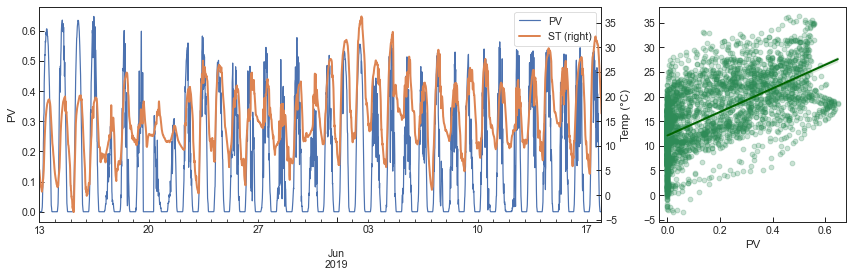

In [11]:
# PV production and surface temp. data series plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), 
                       gridspec_kw={'width_ratios': [3, 1]})
df.plot(y='PV', ax=ax[0])
df.plot(y='ST', lw=2, ax=ax[0], secondary_y=True)
ax[0].set_ylabel('PV')
ax[0].right_ax.set_ylabel('Temp (°C)')
sns.regplot(x='PV', y='ST', data=df, ax=ax[1], color='seagreen', 
            line_kws={'color':'darkgreen', 'linewidth':2},
            scatter_kws={'alpha':0.25})
ax[1].set_xlabel('PV')
ax[1].set_ylabel('')
fig.tight_layout()
plt.show()

In [12]:
filtered, outliers = sandbox.hampel_filter(df['ST'], window_size=8)

Found 13 outliers within 3 standard deviations.
Overwriting outliers with rolling median values!


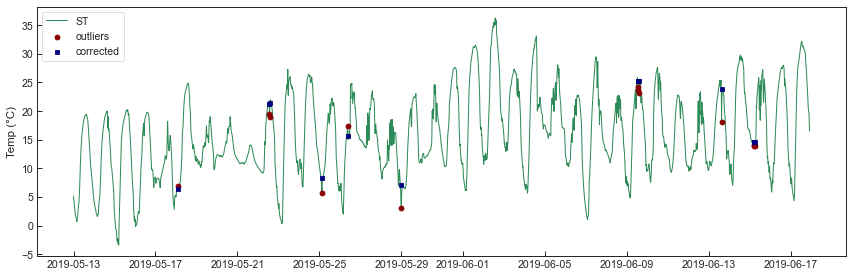

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df['ST'].index, df['ST'].values, lw=1, c='seagreen', label='ST', zorder=1)
ax.scatter(df['ST'].index[outliers], df['ST'].values[outliers], 
           marker='o', c='darkred', s=25, label='outliers', zorder=2)
ax.scatter(filtered.index[outliers], filtered.values[outliers], 
           marker='s', c='navy', s=20, label='corrected', zorder=2)
ax.set_ylabel('Temp (°C)')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

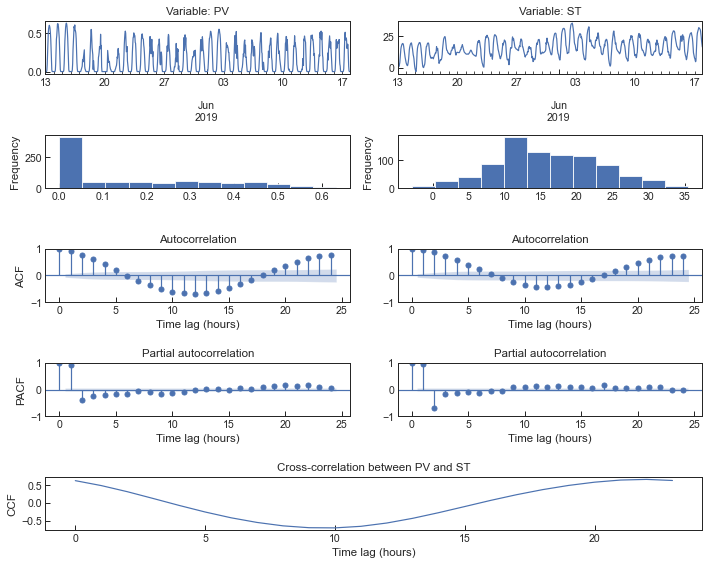

In [14]:
sandbox.plot_correlations(df, column_names=['PV', 'ST'])

In [15]:
# Pearson correlation between PV production and surface temperature
df[['PV', 'ST']].corr()

,PV,ST
PV,1.000000,0.617106
ST,0.617106,1.000000


### Features engineering from time-series data

In [16]:
# Single-step model
df2 = sandbox.engineer_features(df)
df2.head()

,CD,CM,CU,PREC,RH2m,ST,SWD,TT2M,WS100m,WS10m,...,WS10m_diff,PV_diff24,roll_mean,roll_max,hr_sin,hr_cos,mnth_sin,mnth_cos,sun,PV+0h
2019-05-14 00:00:00+00:00,0.0000,0.0,0.0000,0.0000,85.8925,3.9450,0.0,5.4000,8.1800,2.1325,...,-0.0275,0.000000,0.379288,0.605172,0.000000,1.000000,0.866025,-0.5,0,0.000000
2019-05-14 01:00:00+00:00,0.0000,0.0,0.0000,0.0000,92.6575,3.1425,0.0,4.5875,8.0875,2.1425,...,0.0100,0.000000,0.370245,0.605172,0.258819,0.965926,0.866025,-0.5,0,0.000000
2019-05-14 02:00:00+00:00,0.0000,0.0,0.0000,0.0000,96.3300,2.3450,0.0,3.7775,7.3275,2.0050,...,-0.1375,0.000000,0.351436,0.605172,0.500000,0.866025,0.866025,-0.5,0,0.000000
2019-05-14 03:00:00+00:00,0.0000,0.0,0.0075,0.0000,98.2700,1.8450,0.0,3.2275,7.3975,2.1025,...,0.0975,0.000070,0.324255,0.605172,0.707107,0.707107,0.866025,-0.5,1,0.000585
2019-05-14 04:00:00+00:00,0.2175,0.0,0.0025,0.0025,99.7150,1.7575,0.0,2.9500,7.1150,2.1775,...,0.0750,0.001079,0.290719,0.605172,0.866025,0.500000,0.866025,-0.5,1,0.017226


### Train, validation, and test datasets (time-series data)

In [17]:
# Hour-ahead weather forecast is NOT being utilized
weather_forecast = False
# Prepare dataframe for a split into train, test sets
X, y = sandbox.prepare_data(df2)

In [18]:
# Train and test dataset split (w/o shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [19]:
# Print train and test set shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(671, 283) (671, 1)
(168, 283) (168, 1)


### Single-step model pipeline with features selection

In [20]:
model = 'SVR'

In [21]:
search = sandbox.single_step_model(model, X_train, y_train)

Working ...
Execution time (hour:min:sec): 0:00:35.294498
Best parameter (CV score = -0.001):
{'estimator__C': 65.6814113922735, 'estimator__epsilon': 5.336447357528417e-05, 'kbest__k': 32, 'preprocess': StandardScaler()}


In [22]:
# Nested cross-validation for estimating model's variance
# https://www.youtube.com/watch?v=DuDtXtKNpZs&list=PLGVZCDnMOq0qtkoXglrDC6pS8NvY94QQw&index=5
nested_model_scores = cross_val_score(estimator=search, 
                                      X=X_train, y=y_train.values.ravel(), 
                                      scoring='neg_mean_squared_error',
                                      cv=TimeSeriesSplit(n_splits=3), 
                                      n_jobs=-1)
print([score.round(4) for score in nested_model_scores])

[-0.0026, -0.0022, -0.0002]


#### Feature importance analysis

In [23]:
if model == 'RandomForest':
    # Feature importance analysis 
    best_params = {'n_estimators': search.best_params_['estimator__n_estimators'],
                   'max_depth': search.best_params_['estimator__max_depth'],
                   'max_samples': search.best_params_['estimator__max_samples'],
                  }
    forest = RandomForestRegressor(criterion='mse', **best_params)
    forest.fit(X_train, y_train)

    TOP = 15
    feature_importance = forest.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[-TOP:]
    pos = np.arange(sorted_idx.shape[0]) + .25

    # Plot relative feature importance
    fig, ax = plt.subplots(figsize=(7,5))
    ax.barh(pos, feature_importance[sorted_idx][-TOP:], 
            align='center', color='magenta', alpha=0.6)
    plt.yticks(pos, X_train.columns[sorted_idx][-TOP:])
    ax.set_xlabel('Feature Relative Importance')
    ax.grid(axis='x')
    plt.tight_layout()
    plt.show()

### Single-step ahead prediction

In [24]:
X_test.head()

,PV_1h,PV_2h,PV_3h,PV_4h,PV_5h,PV_6h,PV_7h,PV_8h,PV_9h,PV_10h,...,WS100m_diff,WS10m_diff,PV_diff24,roll_mean,roll_max,hr_sin,hr_cos,mnth_sin,mnth_cos,sun
2019-06-10 23:00:00+00:00,0.0,0.0,0.0,0.004382,0.020568,0.034669,0.022396,0.053528,0.175738,0.341665,...,-0.1300,-0.2100,0.000000,0.235989,0.458723,-0.258819,0.965926,0.5,-0.866025,0
2019-06-11 00:00:00+00:00,0.0,0.0,0.0,0.000000,0.004382,0.020568,0.034669,0.022396,0.053528,0.175738,...,0.3300,0.0150,0.000000,0.228333,0.458723,0.000000,1.000000,0.5,-0.866025,0
2019-06-11 01:00:00+00:00,0.0,0.0,0.0,0.000000,0.000000,0.004382,0.020568,0.034669,0.022396,0.053528,...,1.0900,0.6375,0.000000,0.214500,0.458723,0.258819,0.965926,0.5,-0.866025,0
2019-06-11 02:00:00+00:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.004382,0.020568,0.034669,0.022396,...,-0.2350,-0.0825,0.000000,0.195516,0.458723,0.500000,0.866025,0.5,-0.866025,0
2019-06-11 03:00:00+00:00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.004382,0.020568,0.034669,...,-0.8775,-0.5400,0.000662,0.172789,0.458723,0.707107,0.707107,0.5,-0.866025,1


In [25]:
# Make single-step predictions for 24 hours ahead
y_preds = search.predict(X_test.values[:24,:])

In [26]:
mse = mean_squared_error(y_test.values[:24], y_preds)
print('MSE:', mse.round(5))
mae = mean_absolute_error(y_test.values[:24], y_preds)
print('MAE:', mae.round(5))

MSE: 1e-05
MAE: 0.00253


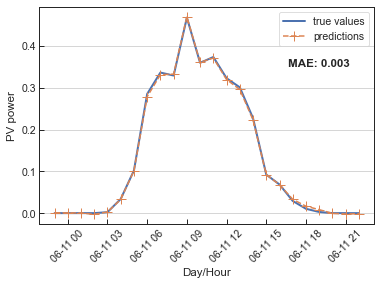

In [27]:
plt.figure(figsize=(6,4))
plt.plot(y_test.index[:24], y_test.values[0:24], lw=2, label='true values')
plt.plot(y_test.index[:24], y_preds, ls='--', lw=1.5, marker='+', ms=10, label='predictions')
plt.text(y_test.index[20], 0.35, 'MAE: {:.3f}'.format(mae), horizontalalignment='center', fontweight='bold')
plt.legend(loc='upper right')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.xlabel('Day/Hour')
plt.ylabel('PV power')
plt.show()

### Walk-forward multi-step prediction with a single-step model

In [28]:
WALK = 12  # walk-forward for WALK hours
STEP = 24  # multi-step predict for STEP hours ahead
# With STEP=24 and WALK=12, we are making a 24-hour ahead predictions 
# after each hour, and move forward in time for 12 hours in total. 
# In other words, we walk forward for 12 hours, and each time we move 
# forward (by one hour) we make a brand new 24-hour ahead predictions. 
# Predicted values are being utilized as past observations for making
# new predictions as we walk forward in time. Hence, as we move away in 
# time from the present moment we are relying more and more on predicted 
# values to make new predictions!

In [29]:
def plot_predictions(walk, y_test, y_pred):
    plt.figure(figsize=(6,4))
    plt.title('walk forward +{:2d} hours'.format(walk+1))
    plt.plot(y_test.values[walk:walk+STEP], lw=2.5, label='true values')
    plt.plot(y_pred, ls='--', lw=1.5, marker='+', ms=10, label='predictions')
    mae = mean_absolute_error(y_test.values[walk:walk+STEP], y_pred)
    plt.text(STEP-2, 0.35, 'MAE: {:.3f}'.format(mae), 
             horizontalalignment='right', 
             fontweight='bold')
    plt.legend(loc='upper right')
    plt.ylim(top=0.5)
    plt.grid(axis='y')
    plt.xlabel('Hour')
    plt.ylabel('PV power')
    plt.show()

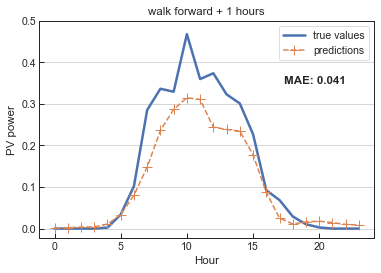

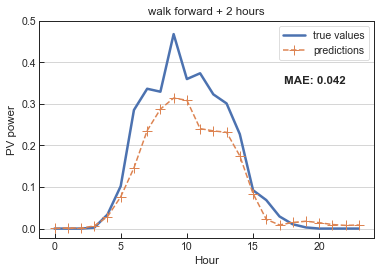

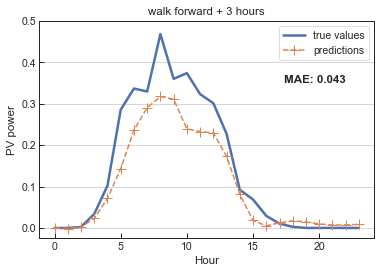

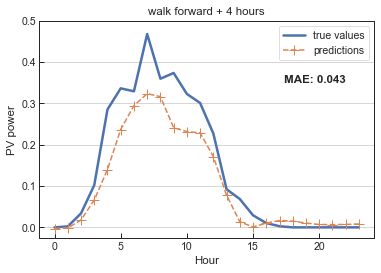

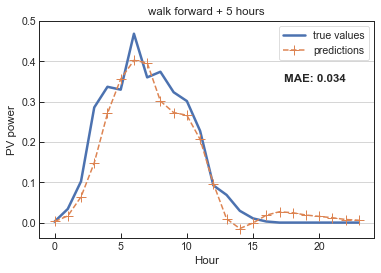

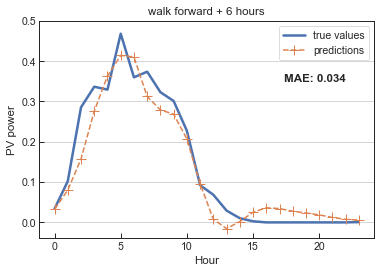

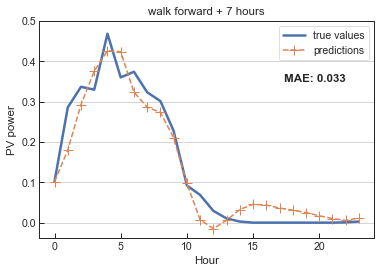

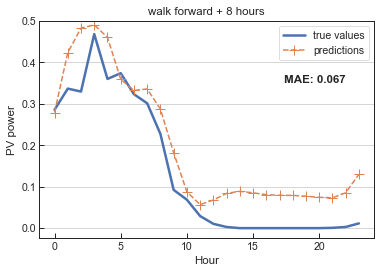

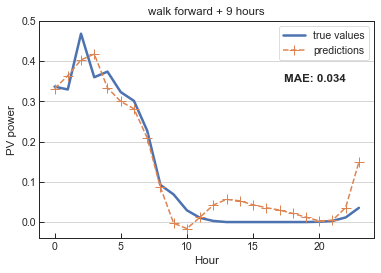

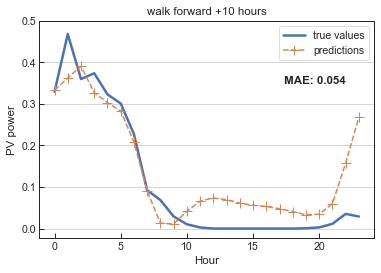

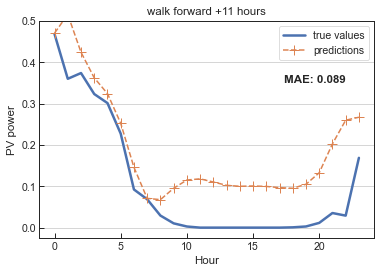

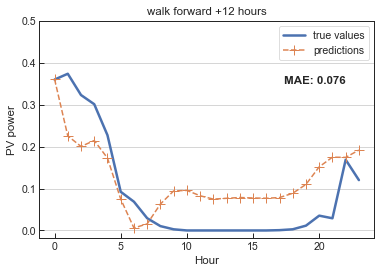

In [30]:
# Do walk-forward predictions (ONLY if weather_forecast == False)
for k in range(WALK):
    X_test_values = X_test.values[k,:]
    y_pred_values = []
    for i in range(STEP):
        # Predict next time-step value
        y_predict = search.predict(X_test_values.reshape(1,-1))[0]
        y_pred_values.append(y_predict)
        # Walk-forward for a single time step
        X_test_values = sandbox.walk_forward(X_test_values, y_predict)
    # Plot walk-forward predictions against true values
    plot_predictions(k, y_test, y_pred_values)

### Multi-step model pipeline without features selection

In [31]:
# Multi-step model (24-hours ahead)
df2 = sandbox.engineer_features(df, steps_ahead=STEP)
# Prepare dataframe for a split into train, test sets
X, y = sandbox.prepare_data(df2)

In [32]:
# Train and test dataset split (w/o shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=False)

In [33]:
# Print train and test set shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(652, 283) (652, 24)
(164, 283) (164, 24)


In [34]:
X_test.head()

,PV_1h,PV_2h,PV_3h,PV_4h,PV_5h,PV_6h,PV_7h,PV_8h,PV_9h,PV_10h,...,WS100m_diff,WS10m_diff,PV_diff24,roll_mean,roll_max,hr_sin,hr_cos,mnth_sin,mnth_cos,sun
2019-06-10 04:00:00+00:00,0.001658,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.010728,0.053106,...,-0.6425,0.2550,-0.016527,0.167554,0.501012,0.866025,5.000000e-01,0.5,-0.866025,1
2019-06-10 05:00:00+00:00,0.033423,0.001658,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.010728,...,-0.5700,-0.7950,-0.040255,0.142239,0.501012,0.965926,2.588190e-01,0.5,-0.866025,1
2019-06-10 06:00:00+00:00,0.104432,0.033423,0.001658,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.1575,-0.3150,-0.086851,0.118082,0.501012,1.000000,6.123234e-17,0.5,-0.866025,1
2019-06-10 07:00:00+00:00,0.208475,0.104432,0.033423,0.001658,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.5600,0.2925,-0.015832,0.096297,0.501012,0.965926,-2.588190e-01,0.5,-0.866025,1
2019-06-10 08:00:00+00:00,0.366869,0.208475,0.104432,0.033423,0.001658,0.0,0.0,0.0,0.000000,0.000000,...,-0.5625,0.3925,-0.064800,0.078713,0.501012,0.866025,-5.000000e-01,0.5,-0.866025,1


In [35]:
multi_model = 'ChainSVR'

In [36]:
search_multi = sandbox.multi_step_model(multi_model, X_train, y_train)

Working ...
Execution time (hour:min:sec): 0:01:55.426473
Best parameter (CV score = -0.011):
{'preprocess': None, 'svr__base_estimator__C': 1.0942666836846573, 'svr__base_estimator__epsilon': 5.000561157110994e-05}


In [37]:
def plot_multi_step_predictions(walk, y_test, y_pred):
    plt.figure(figsize=(6,4))
    plt.title('walk forward +{:2d} hours'.format(walk+1))
    plt.plot(y_test, lw=2.5, label='true values')
    plt.plot(y_pred, ls='--', lw=1.5, marker='+', ms=10, label='predictions')
    mae = mean_absolute_error(y_test, y_pred)
    plt.text(STEP-2, 0.35, 'MAE: {:.3f}'.format(mae), 
             horizontalalignment='right', 
             fontweight='bold')
    plt.legend(loc='upper right')
    plt.ylim(top=0.5)
    plt.grid(axis='y')
    plt.xlabel('Hour')
    plt.ylabel('PV power')
    plt.show()

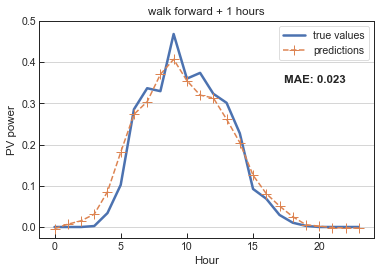

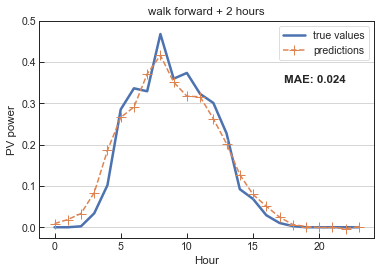

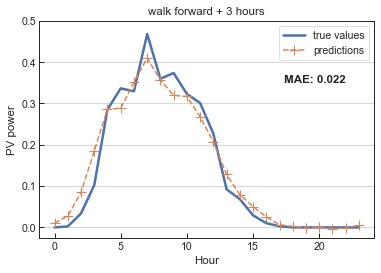

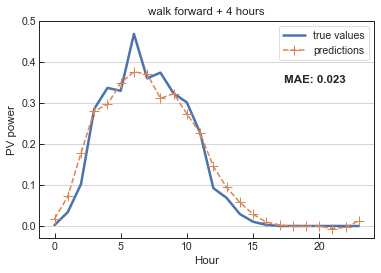

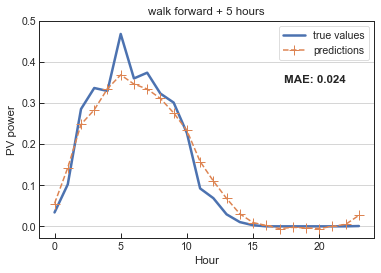

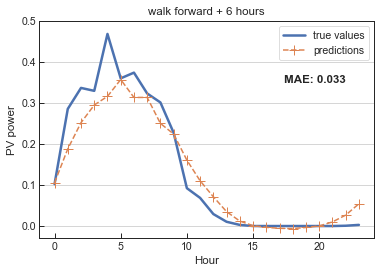

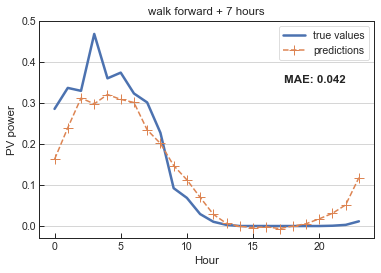

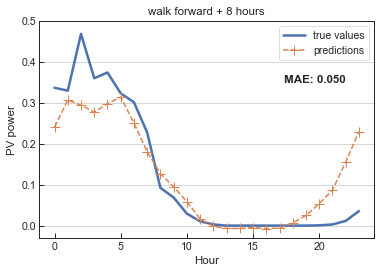

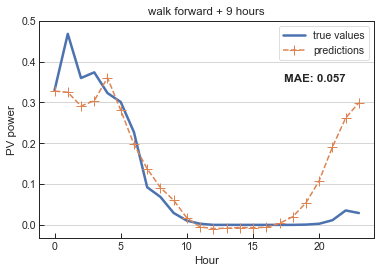

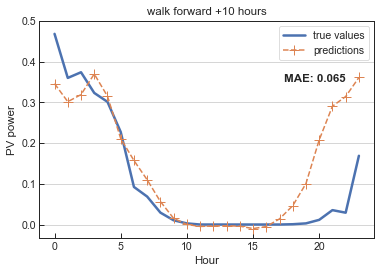

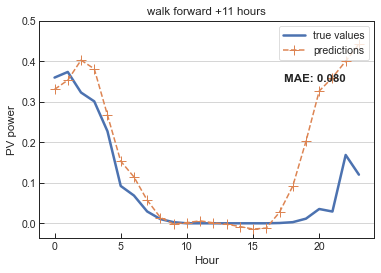

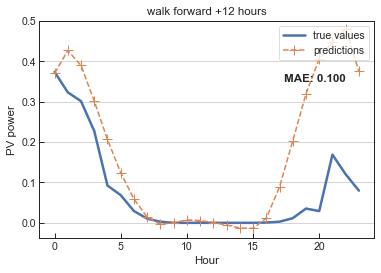

In [38]:
# Do multi-step ahead predictions
for k in range(WALK):
    X_test_values = X_test.values[k+20,:]  # +20 hard-coded shift to align views with those
    y_test_values = y_test.values[k+20,:]  # of walk-forward predictions for easy comparison
    y_predict = search_multi.predict(X_test_values.reshape(1,-1)).flatten()
    # Plot multi-step predictions against true values
    plot_multi_step_predictions(k, y_test_values, y_predict)